In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [11]:
from transformers import RobertaTokenizer, RobertaTokenizerFast
from transformers import RobertaForSequenceClassification
from transformers import RobertaConfig, RobertaModel, RobertaForMaskedLM
from transformers import LineByLineTextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments
import torch
import matplotlib.pyplot as plt
import pandas as pd
import random


In [3]:
maskedlm_model = RobertaForMaskedLM.from_pretrained("roberta-large")

In [4]:
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-large", do_lower_case=True)

In [6]:
print(tokenizer.tokenize('covid'))
print(tokenizer.tokenize('coronavirus'))
print(tokenizer.tokenize('cdc'))

['c', 'ov', 'id']
['cor', 'on', 'av', 'irus']


In [7]:
print (len(tokenizer)) 
tokenizer.add_tokens(["covid"]) 
tokenizer.add_tokens(["coronavirus"])
tokenizer.add_tokens(["cdc"])
print (len(tokenizer)) 

50265
50267


In [8]:
print(tokenizer.tokenize('covid'))
print(tokenizer.tokenize('coronavirus'))
print(tokenizer.tokenize('cdc'))

['covid']
['coronavirus']


In [9]:
test_sentence = "covid and coronavirus are bad, cdc is good authority truth on health"
print(tokenizer.tokenize(test_sentence))

['covid', 'Ġand', 'Ġ', 'coronavirus', 'Ġare', 'Ġbad']


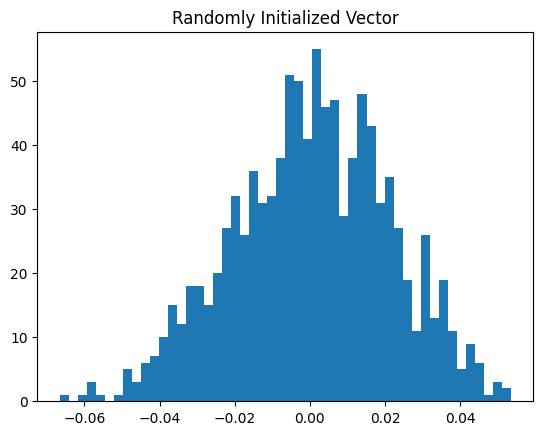

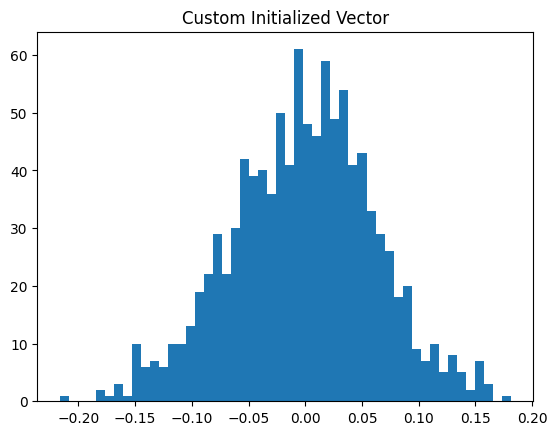

In [10]:
# FOR CORONAVIRUS:
maskedlm_model.resize_token_embeddings(len(tokenizer)) 
random_vector = maskedlm_model.get_input_embeddings().weight[-1].detach().numpy() # last one is covid random vector

plt.title("Randomly Initialized Vector")
plt.hist(random_vector, bins=50)
plt.show()

pandemic_id = tokenizer.convert_tokens_to_ids("pandemic")
virus_id = tokenizer.convert_tokens_to_ids("virus")
respiratory_id = tokenizer.convert_tokens_to_ids("respiratory")
virus_embedding = maskedlm_model.get_input_embeddings().weight[virus_id]
pandemic_embedding = maskedlm_model.get_input_embeddings().weight[pandemic_id]
respiratory_embedding = maskedlm_model.get_input_embeddings().weight[respiratory_id]
mean_embedding = torch.mean(torch.stack([virus_embedding, respiratory_embedding, pandemic_embedding]), dim=0)
maskedlm_model.get_input_embeddings().weight[-1].data[:] = mean_embedding
mean_vector = maskedlm_model.get_input_embeddings().weight[-1].detach().numpy()

plt.title("Custom Initialized Vector")
plt.hist(mean_vector, bins=50)
plt.show()

# For COVID:
maskedlm_model.resize_token_embeddings(len(tokenizer)) 
random_vector = maskedlm_model.get_input_embeddings().weight[-2].detach().numpy() # last one is covid random vector

mean_embedding = torch.mean(torch.stack([virus_embedding, respiratory_embedding, pandemic_embedding]), dim=0)
maskedlm_model.get_input_embeddings().weight[-2].data[:] = mean_embedding


In [ ]:
dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="../../data/pretraining_tweets_en_full_clean.txt",
    block_size=32,
)

In [87]:
# Custom DataCollator for Language Modeling
class CustomDataCollatorForLM(DataCollatorForLanguageModeling):

    def __init__(self, tokenizer, mlm=True, mlm_probability=0.15):
        super().__init__(tokenizer, mlm=mlm, mlm_probability=mlm_probability)
        self.custom_masked_tokens = []
        self.custom_masked_probability = mlm_probability

    def add_custom_masked_tokens(self, tokens, probability):
        self.custom_masked_tokens.extend(tokens)
        self.custom_masked_probability = probability
    
    def collate_batch(self, features):
        inputs = self.tokenizer.pad({"input_ids": [f.input_ids for f in features]}, return_tensors="pt")
        labels = inputs["input_ids"].clone() 

        for i, feature in enumerate(features):
            masked_indices = random.sample(range(len(feature.input_ids)), int(self.custom_masked_probability * len(feature.input_ids)))

            for idx in masked_indices:
                if feature.input_ids[idx] in self.custom_masked_tokens:
                    labels[i, idx] = self.tokenizer.mask_token_id

        return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": labels}

In [ ]:
# Set up training arguments
training_args = TrainingArguments(   
    output_dir="./",
    overwrite_output_dir=True,
    learning_rate=3e-05, 
    num_train_epochs=1,
    per_device_train_batch_size=32,
    save_steps=10000,
    #save_total_limit=2,
)

# Set up the Trainer with custom data collator
trainer = Trainer(
    model=maskedlm_model,
    args=training_args,
    data_collator=CustomDataCollatorForLM(tokenizer=tokenizer, mlm=True, mlm_probability=0.15),
    train_dataset=dataset,
)

# Add custom masked tokens with probability
custom_masked_tokens = ["covid", "coronavirus", "cdc"]
custom_masked_probability = 0.15  # Adjust as needed


In [89]:
trainer.data_collator.add_custom_masked_tokens(custom_masked_tokens, custom_masked_probability)


In [ ]:
# Start pretraining
trainer.train()

In [ ]:
trainer.save_model("covid_roberta_15_masked")

In [ ]:
tokenizer.save_pretrained("covid_roberta_15_masked")